## Basic information
#### frame of thickness is 0.084 mm


#### Read TIFF image stack

In [3]:
from PIL import Image
import numpy as np

# Read TIFF
img = Image.open("data/020150.tiff")

frames = []
try:
    while True:
        frame = np.array(img.convert("L"))  # grayscale
        frames.append(frame)
        img.seek(img.tell() + 1)
except EOFError:
    pass  # End of file reached

print(f"total {len(frames)} frames")


total 2760 frames


#### 在每帧中检测圆形（麦秆）

In [4]:
import cv2
import numpy as np

def detect_stalk_circle(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # 提升对比度
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    # 高斯模糊（比中值模糊更适合平滑边缘）
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # 圆检测
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2,
                               minDist=20, param1=50, param2=20,
                               minRadius=15, maxRadius=35)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        output = frame.copy()
        for i in circles[0, :]:
            # 可视化圆
            cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)
        # cv2.imshow("Detected Circle", output)
        cv2.waitKey(0)
        return True
    return False


#### 找出麦秆开始和结束的帧

In [5]:
start_frame = None
end_frame = None

for i, frame in enumerate(frames):
    # Convert grayscale frame to BGR (3-channel) for processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    if detect_stalk_circle(frame_rgb):
        if start_frame is None:
            start_frame = i
        end_frame = i  # 每次检测到都更新结束帧

if start_frame is not None and end_frame is not None:
    print(f"麦秆从第 {start_frame} 帧到第 {end_frame} 帧")
else:
    print("未检测到麦秆圆形")



麦秆从第 750 帧到第 2599 帧


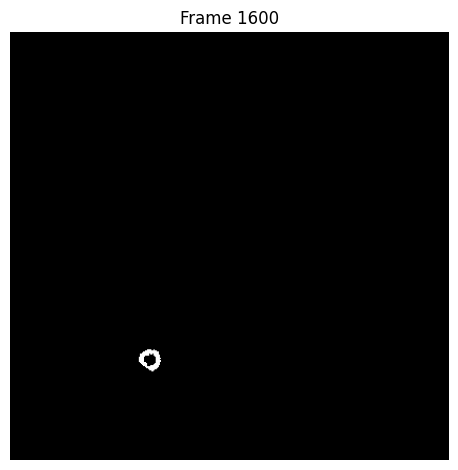

In [8]:
import matplotlib.pyplot as plt

# 设置你要查看的帧编号
target_frame = 1600  # 改成你要查看的帧编号

# 定位到该帧
img.seek(target_frame)

# 转灰度并转为数组
frame = np.array(img.convert("L"))

# 显示该帧
plt.imshow(frame, cmap='gray')
plt.title(f"Frame {target_frame}")
plt.axis("off")
plt.tight_layout()
plt.show()

#### 质心追踪

TIFF shape: (2760, 406, 416)
检测到的有效点数: 52
剔除的异常点数: 0
麦秆的估计长度: 183.69 mm


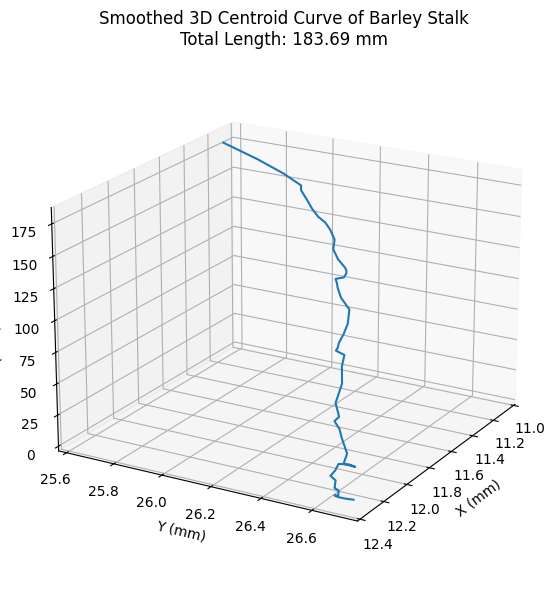

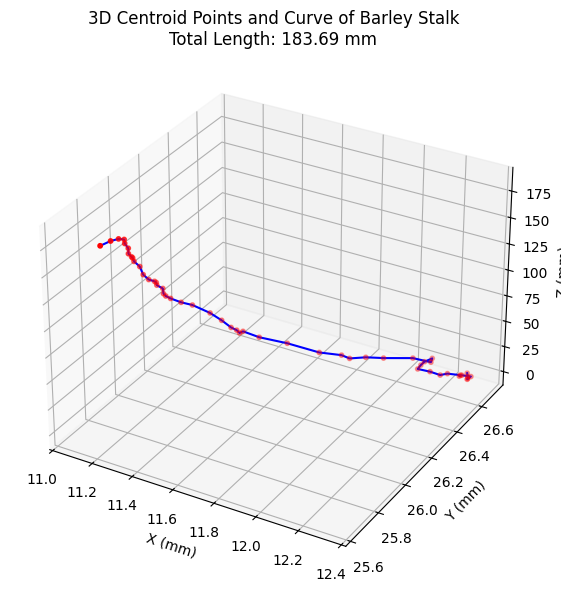

In [11]:
import cv2
import numpy as np
import tifffile
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

# 参数
start_frame = 1496
end_frame = 2597
pixel_spacing = 0.084  # mm
z_spacing = 1.0  # CT 间距，单位 mm
min_area = 200  # 噪声面积过滤阈值（可调）

# 载入 tiff 图像堆栈
stack = tifffile.imread("data/020150.tiff")
print(f"TIFF shape: {stack.shape}")  # (num_frames, H, W)

# 存储麦秆轨迹
centroids = []
areas = []  # 存储面积，用于异常检测

# 帧间最大位移限制（可调）
max_xy_displacement = 5  # 像素
last_valid_centroid = None

# 遍历所有帧
for i in range(start_frame, end_frame + 1):
    frame = stack[i]
    
    # CLAHE 增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(frame)
    
    # Gamma 校正（增强暗部对比度）
    gamma = 1.5
    gamma_corrected = np.power(enhanced / 255.0, gamma) * 255
    enhanced = gamma_corrected.astype(np.uint8)
    
    # 二值化
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 轮廓提取
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 面积过滤 + 质心提取
    valid = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    if valid:
        # 如果有多个有效轮廓，可能需要使用历史信息选择最佳匹配
        if len(valid) > 1 and last_valid_centroid is not None:
            # 选择与上一个有效中心点最接近的轮廓
            closest_contour = None
            min_distance = float('inf')
            
            for cnt in valid:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = M["m10"] / M["m00"]
                    cy = M["m01"] / M["m00"]
                    dist = np.sqrt((cx - last_valid_centroid[0])**2 + (cy - last_valid_centroid[1])**2)
                    
                    if dist < min_distance and dist < max_xy_displacement:
                        min_distance = dist
                        closest_contour = cnt
            
            if closest_contour is not None:
                largest = closest_contour
            else:
                largest = max(valid, key=cv2.contourArea)
        else:
            largest = max(valid, key=cv2.contourArea)
        
        M = cv2.moments(largest)
        if M["m00"] != 0:
            cx = M["m10"] / M["m00"]
            cy = M["m01"] / M["m00"]
            cz = i - start_frame  # 注意：这里不应用z_spacing，留到单位转换时
            
            # 存储质心坐标和面积
            centroid = [cx, cy, cz]
            area = cv2.contourArea(largest)
            
            # 检查与上一个点的连续性
            if last_valid_centroid is not None:
                dx = cx - last_valid_centroid[0]
                dy = cy - last_valid_centroid[1]
                displacement = np.sqrt(dx**2 + dy**2)
                
                # 如果移动过大，可能是错误点
                if displacement <= max_xy_displacement:
                    centroids.append(centroid)
                    areas.append(area)
                    last_valid_centroid = centroid
            else:
                # 第一个有效点
                centroids.append(centroid)
                areas.append(area)
                last_valid_centroid = centroid

if not centroids:
    print("未检测到有效麦秆轨迹！")
    exit()

centroids = np.array(centroids)
areas = np.array(areas)

# 识别并剔除异常值 - 使用面积和位置的组合检测
mean_area = np.mean(areas)
std_area = np.std(areas)

valid_indices = []
for i in range(len(centroids)):
    # 检查面积是否在合理范围内
    if abs(areas[i] - mean_area) < 3 * std_area:  # 3倍标准差
        valid_indices.append(i)

centroids = centroids[valid_indices]
areas = areas[valid_indices]

print(f"检测到的有效点数: {len(centroids)}")
print(f"剔除的异常点数: {len(areas) - len(valid_indices)}")

# 平滑处理（可选）- 使用更小的窗口和更低的多项式阶数
if len(centroids) >= 7:  # 使用更小的窗口
    window_length = min(7, len(centroids) // 2 * 2 - 1)  # 确保是奇数
    for axis in range(3):  # x, y, z
        centroids[:, axis] = savgol_filter(centroids[:, axis], 
                                          window_length=window_length, 
                                          polyorder=2)  # 降低多项式阶数

# 正确地转换为物理单位 (mm)
centroids_mm = np.zeros_like(centroids, dtype=float)
centroids_mm[:, 0] = centroids[:, 0] * pixel_spacing  # X轴
centroids_mm[:, 1] = centroids[:, 1] * pixel_spacing  # Y轴
centroids_mm[:, 2] = centroids[:, 2] * z_spacing      # Z轴

# 计算麦秆的实际长度
diffs = np.diff(centroids_mm, axis=0)  # 计算相邻点的差值
segment_lengths = np.linalg.norm(diffs, axis=1)  # 计算欧几里得距离
total_length = np.sum(segment_lengths)  # 总长度

print(f"麦秆的估计长度: {total_length:.2f} mm")

# 3D 可视化
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制平滑曲线
ax.plot(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2])

# 设置坐标轴标签
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")

# 设置图表标题，包含长度信息
plt.title(f"Smoothed 3D Centroid Curve of Barley Stalk\nTotal Length: {total_length:.2f} mm")

# 调整视角以更好地观察曲线
ax.view_init(elev=20, azim=30)  # 调整仰角和方位角

plt.tight_layout()
plt.show()

# 额外:生成带有点的图，以便观察点的分布
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制点和线
ax.plot(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2], 'b-')
ax.scatter(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2], c='r', s=10)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
plt.title(f"3D Centroid Points and Curve of Barley Stalk\nTotal Length: {total_length:.2f} mm")

plt.tight_layout()
plt.show()

#### 寻找麦秆顶端向下5cm处位置

TIFF shape: (2760, 406, 416)
检测到的有效点数: 52
剔除的异常点数: 0
麦秆的估计长度: 183.69 mm
最小Z值索引: 0, Z值: -0.00 mm
最大Z值索引: 51, Z值: 183.67 mm
识别的顶端索引: 51
从顶端起5cm处的点索引: 27
从顶端起5cm处的实际累积长度: 50.59 mm
从顶端起5cm处的点坐标(mm): X=11.41, Y=26.23, Z=50.57


/tmp/ipykernel_956079/1758795656.py:261: UserWarning: Glyph 39030 (\N{CJK UNIFIED IDEOGRAPH-9876}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1758795656.py:261: UserWarning: Glyph 31471 (\N{CJK UNIFIED IDEOGRAPH-7AEF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1758795656.py:261: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1758795656.py:261: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1758795656.py:261: UserWarning: Glyph 22788 (\N{CJK UNIFIED IDEOGRAPH-5904}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1758795656.py:261: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1758795656.py:261: UserWarning: Glyph 38469 (\N{CJK UN

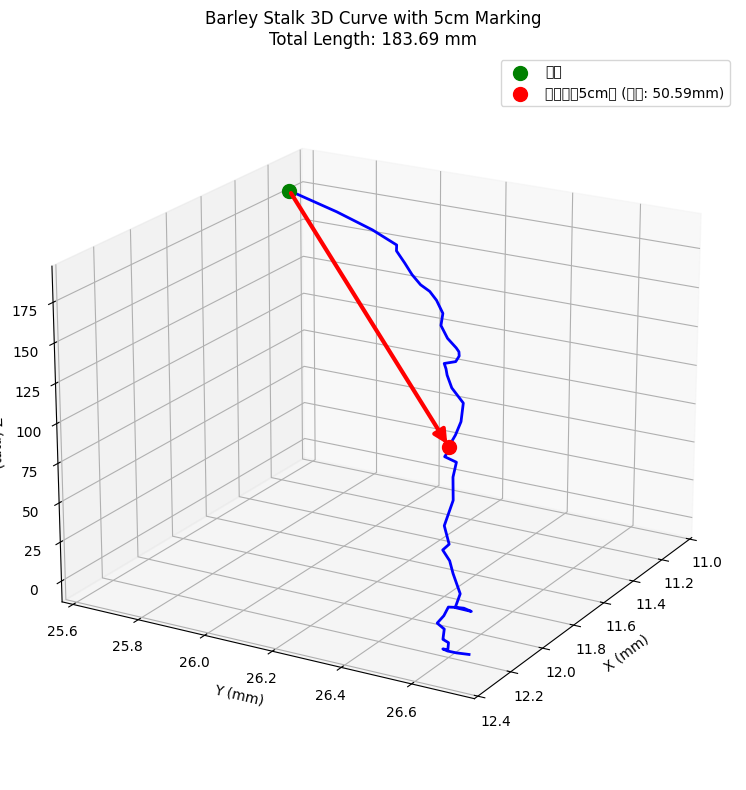

顶端5cm段的平均曲率估计: 0.026615
顶端5cm段的弯曲角度估计: 2.22°


In [1]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# 自定义3D箭头类，用于标记特定点
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# 参数
start_frame = 1496
end_frame = 2597
pixel_spacing = 0.084  # mm
z_spacing = 1.0  # CT 间距，单位 mm
min_area = 200  # 噪声面积过滤阈值（可调）
target_distance = 50  # 目标距离：5cm = 50mm

# 载入 tiff 图像堆栈
stack = tifffile.imread("data/020150.tiff")
print(f"TIFF shape: {stack.shape}")  # (num_frames, H, W)

# 存储麦秆轨迹
centroids = []
areas = []  # 存储面积，用于异常检测

# 帧间最大位移限制（可调）
max_xy_displacement = 5  # 像素
last_valid_centroid = None

# 遍历所有帧
for i in range(start_frame, end_frame + 1):
    frame = stack[i]
    
    # CLAHE 增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(frame)
    
    # Gamma 校正（增强暗部对比度）
    gamma = 1.5
    gamma_corrected = np.power(enhanced / 255.0, gamma) * 255
    enhanced = gamma_corrected.astype(np.uint8)
    
    # 二值化
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 轮廓提取
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 面积过滤 + 质心提取
    valid = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    if valid:
        # 如果有多个有效轮廓，可能需要使用历史信息选择最佳匹配
        if len(valid) > 1 and last_valid_centroid is not None:
            # 选择与上一个有效中心点最接近的轮廓
            closest_contour = None
            min_distance = float('inf')
            
            for cnt in valid:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = M["m10"] / M["m00"]
                    cy = M["m01"] / M["m00"]
                    dist = np.sqrt((cx - last_valid_centroid[0])**2 + (cy - last_valid_centroid[1])**2)
                    
                    if dist < min_distance and dist < max_xy_displacement:
                        min_distance = dist
                        closest_contour = cnt
            
            if closest_contour is not None:
                largest = closest_contour
            else:
                largest = max(valid, key=cv2.contourArea)
        else:
            largest = max(valid, key=cv2.contourArea)
        
        M = cv2.moments(largest)
        if M["m00"] != 0:
            cx = M["m10"] / M["m00"]
            cy = M["m01"] / M["m00"]
            cz = i - start_frame  # 注意：这里不应用z_spacing，留到单位转换时
            
            # 存储质心坐标和面积
            centroid = [cx, cy, cz]
            area = cv2.contourArea(largest)
            
            # 检查与上一个点的连续性
            if last_valid_centroid is not None:
                dx = cx - last_valid_centroid[0]
                dy = cy - last_valid_centroid[1]
                displacement = np.sqrt(dx**2 + dy**2)
                
                # 如果移动过大，可能是错误点
                if displacement <= max_xy_displacement:
                    centroids.append(centroid)
                    areas.append(area)
                    last_valid_centroid = centroid
            else:
                # 第一个有效点
                centroids.append(centroid)
                areas.append(area)
                last_valid_centroid = centroid

if not centroids:
    print("未检测到有效麦秆轨迹！")
    exit()

centroids = np.array(centroids)
areas = np.array(areas)

# 识别并剔除异常值 - 使用面积和位置的组合检测
mean_area = np.mean(areas)
std_area = np.std(areas)

valid_indices = []
for i in range(len(centroids)):
    # 检查面积是否在合理范围内
    if abs(areas[i] - mean_area) < 3 * std_area:  # 3倍标准差
        valid_indices.append(i)

centroids = centroids[valid_indices]
areas = areas[valid_indices]

print(f"检测到的有效点数: {len(centroids)}")
print(f"剔除的异常点数: {len(areas) - len(valid_indices)}")

# 平滑处理（可选）- 使用更小的窗口和更低的多项式阶数
if len(centroids) >= 7:  # 使用更小的窗口
    window_length = min(7, len(centroids) // 2 * 2 - 1)  # 确保是奇数
    for axis in range(3):  # x, y, z
        centroids[:, axis] = savgol_filter(centroids[:, axis], 
                                          window_length=window_length, 
                                          polyorder=2)  # 降低多项式阶数

# 正确地转换为物理单位 (mm)
centroids_mm = np.zeros_like(centroids, dtype=float)
centroids_mm[:, 0] = centroids[:, 0] * pixel_spacing  # X轴
centroids_mm[:, 1] = centroids[:, 1] * pixel_spacing  # Y轴
centroids_mm[:, 2] = centroids[:, 2] * z_spacing      # Z轴

# 计算麦秆的实际长度
diffs = np.diff(centroids_mm, axis=0)  # 计算相邻点的差值
segment_lengths = np.linalg.norm(diffs, axis=1)  # 计算欧几里得距离
total_length = np.sum(segment_lengths)  # 总长度

print(f"麦秆的估计长度: {total_length:.2f} mm")

# 修正：判断点的顺序
# 通过查看Z坐标判断哪端是顶部（Z值较大的通常是顶部）
z_values = centroids_mm[:, 2]
z_min_idx = np.argmin(z_values)
z_max_idx = np.argmax(z_values)

print(f"最小Z值索引: {z_min_idx}, Z值: {z_values[z_min_idx]:.2f} mm")
print(f"最大Z值索引: {z_max_idx}, Z值: {z_values[z_max_idx]:.2f} mm")

# 我们假设Z值较大的是顶端
top_idx = z_max_idx
print(f"识别的顶端索引: {top_idx}")

# 计算从顶端出发的累积长度
cumulative_lengths = np.zeros(len(centroids_mm))

# 如果顶端是最后一个点，我们需要反向计算累积长度
if top_idx == len(centroids_mm) - 1:
    # 反转点的顺序用于计算
    reversed_points = centroids_mm[::-1]
    rev_diffs = np.diff(reversed_points, axis=0)
    rev_lengths = np.linalg.norm(rev_diffs, axis=1)
    rev_cum_lengths = np.zeros(len(reversed_points))
    rev_cum_lengths[1:] = np.cumsum(rev_lengths)
    
    # 将累积长度映射回原始点顺序
    cumulative_lengths = rev_cum_lengths[::-1]
    
    # 调整为从顶端（最高点）开始的距离
    cumulative_lengths = cumulative_lengths.max() - cumulative_lengths
else:
    # 从顶端到每个点的距离计算
    # 首先计算顶端之前的点
    if top_idx > 0:
        reversed_points_before = centroids_mm[:top_idx+1][::-1]
        rev_diffs_before = np.diff(reversed_points_before, axis=0)
        rev_lengths_before = np.linalg.norm(rev_diffs_before, axis=1)
        rev_cum_before = np.zeros(len(reversed_points_before))
        rev_cum_before[1:] = np.cumsum(rev_lengths_before)
        
        # 映射回原始顺序
        cumulative_lengths[:top_idx+1] = rev_cum_before[::-1]
        max_before = cumulative_lengths[0]
        cumulative_lengths[:top_idx+1] = max_before - cumulative_lengths[:top_idx+1]
    
    # 然后计算顶端之后的点
    if top_idx < len(centroids_mm) - 1:
        points_after = centroids_mm[top_idx:]
        diffs_after = np.diff(points_after, axis=0)
        lengths_after = np.linalg.norm(diffs_after, axis=1)
        cum_after = np.zeros(len(points_after))
        cum_after[1:] = np.cumsum(lengths_after)
        
        # 赋值到原始数组
        cumulative_lengths[top_idx:] = cum_after

# 找到累积长度最接近5cm的点
target_idx = np.argmin(np.abs(cumulative_lengths - target_distance))
target_point = centroids_mm[target_idx]

print(f"从顶端起5cm处的点索引: {target_idx}")
print(f"从顶端起5cm处的实际累积长度: {cumulative_lengths[target_idx]:.2f} mm")
print(f"从顶端起5cm处的点坐标(mm): X={target_point[0]:.2f}, Y={target_point[1]:.2f}, Z={target_point[2]:.2f}")

# 3D 可视化
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制平滑曲线
ax.plot(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2], 'b-', linewidth=2)

# 标记顶端
ax.scatter(centroids_mm[top_idx, 0], centroids_mm[top_idx, 1], centroids_mm[top_idx, 2], 
           color='green', s=100, label='顶端')

# 标记5cm处的点
ax.scatter(target_point[0], target_point[1], target_point[2], 
           color='red', s=100, label=f'顶端向下5cm处 (实际: {cumulative_lengths[target_idx]:.2f}mm)')

# 在图上添加箭头指向5cm处的点
a = Arrow3D([centroids_mm[top_idx, 0], target_point[0]], 
           [centroids_mm[top_idx, 1], target_point[1]], 
           [centroids_mm[top_idx, 2], target_point[2]], 
           mutation_scale=20, 
           lw=3, arrowstyle="-|>", color="r")
ax.add_artist(a)

# 设置坐标轴标签
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")

# 设置图表标题，包含长度信息
plt.title(f"Barley Stalk 3D Curve with 5cm Marking\nTotal Length: {total_length:.2f} mm")

# 添加图例
ax.legend()

# 调整视角以更好地观察曲线
ax.view_init(elev=20, azim=30)  # 调整仰角和方位角

plt.tight_layout()
plt.show()

# 可选：分析顶端5cm段的形态特征
top_section_indices = np.where(cumulative_lengths <= target_distance)[0]
if len(top_section_indices) >= 3:
    top_segment = centroids_mm[top_section_indices]
    
    # 计算这段的平均曲率（简化计算）
    dx = np.diff(top_segment[:, 0])
    dy = np.diff(top_segment[:, 1])
    dz = np.diff(top_segment[:, 2])
    
    # 一阶导数
    dt = np.sqrt(dx**2 + dy**2 + dz**2)
    
    # 单位切向量
    T = np.column_stack([dx/dt, dy/dt, dz/dt])
    
    # 二阶导数（曲率相关）
    if len(T) >= 2:
        dT = np.diff(T, axis=0)
        ddt = np.sqrt(np.sum(dT**2, axis=1))
        
        # 平均曲率估计
        avg_curvature = np.mean(ddt)
        print(f"顶端5cm段的平均曲率估计: {avg_curvature:.6f}")
        
        # 弯曲角度估计
        if len(T) >= 2:
            start_dir = T[0]
            end_dir = T[-1]
            cos_angle = np.dot(start_dir, end_dir)
            bend_angle = np.arccos(np.clip(cos_angle, -1.0, 1.0)) * 180 / np.pi
            print(f"顶端5cm段的弯曲角度估计: {bend_angle:.2f}°")

#### 寻找点所在的帧

TIFF shape: (2760, 406, 416)
检测到的有效点数: 52
剔除的异常点数: 0
麦秆的估计长度: 183.69 mm
最小Z值索引: 0, Z值: -0.00 mm
最大Z值索引: 51, Z值: 183.67 mm
识别的顶端索引: 51
顶端对应的帧号: 1687
从顶端起5cm处的点索引: 27
从顶端起5cm处的实际累积长度: 50.59 mm
从顶端起5cm处的点坐标(mm): X=11.41, Y=26.23, Z=50.57
从顶端起5cm处的点对应的帧号: 1547
从起始帧(1496)算起的帧偏移量: 51


/tmp/ipykernel_956079/1742761004.py:256: UserWarning: Glyph 24103 (\N{CJK UNIFIED IDEOGRAPH-5E27}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


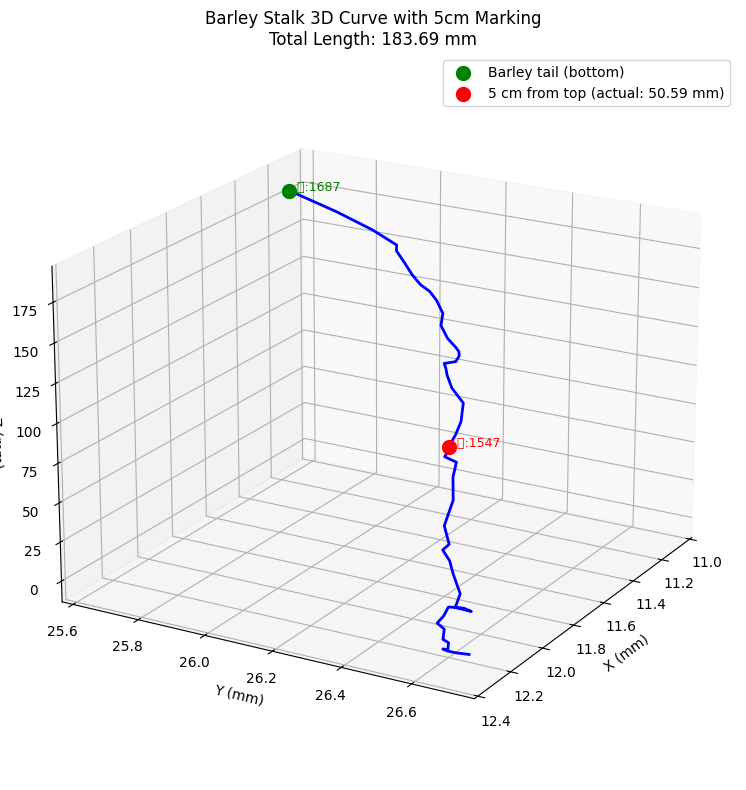


帧号映射表（部分关键点）:
索引    帧号        从顶端距离(mm)           Z坐标(mm)        
--------------------------------------------------
46    1638      141.79              141.76         
47    1646      149.12              149.10         
48    1652      152.83              152.81         
49    1655      161.60              161.57         
50    1657      171.88              171.86         
51    1687      183.69              183.67         


/tmp/ipykernel_956079/1742761004.py:283: UserWarning: Glyph 24103 (\N{CJK UNIFIED IDEOGRAPH-5E27}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1742761004.py:283: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1742761004.py:283: UserWarning: Glyph 20174 (\N{CJK UNIFIED IDEOGRAPH-4ECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1742761004.py:283: UserWarning: Glyph 39030 (\N{CJK UNIFIED IDEOGRAPH-9876}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1742761004.py:283: UserWarning: Glyph 31471 (\N{CJK UNIFIED IDEOGRAPH-7AEF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1742761004.py:283: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_956079/1742761004.py:283: UserWarning: Glyph 32047 (\N{CJK UN

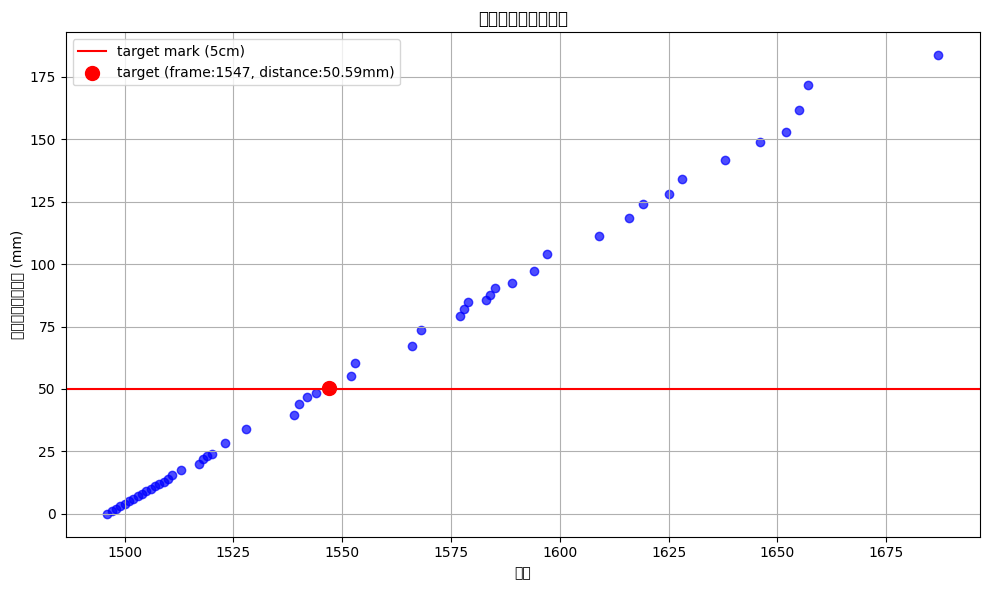

In [3]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

# 参数
start_frame = 1496
end_frame = 2597
pixel_spacing = 0.084  # mm
z_spacing = 1.0  # CT 间距，单位 mm
min_area = 200  # 噪声面积过滤阈值（可调）
target_distance = 50  # 目标距离：5cm = 50mm

# 载入 tiff 图像堆栈
stack = tifffile.imread("data/020150.tiff")
print(f"TIFF shape: {stack.shape}")  # (num_frames, H, W)

# 存储麦秆轨迹和对应的帧号
centroids = []
frame_numbers = []  # 存储每个有效点对应的帧号
areas = []  # 存储面积，用于异常检测

# 帧间最大位移限制（可调）
max_xy_displacement = 5  # 像素
last_valid_centroid = None

# 遍历所有帧
for i in range(start_frame, end_frame + 1):
    frame = stack[i]
    
    # CLAHE 增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(frame)
    
    # Gamma 校正（增强暗部对比度）
    gamma = 1.5
    gamma_corrected = np.power(enhanced / 255.0, gamma) * 255
    enhanced = gamma_corrected.astype(np.uint8)
    
    # 二值化
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 轮廓提取
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 面积过滤 + 质心提取
    valid = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    if valid:
        # 如果有多个有效轮廓，可能需要使用历史信息选择最佳匹配
        if len(valid) > 1 and last_valid_centroid is not None:
            # 选择与上一个有效中心点最接近的轮廓
            closest_contour = None
            min_distance = float('inf')
            
            for cnt in valid:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = M["m10"] / M["m00"]
                    cy = M["m01"] / M["m00"]
                    dist = np.sqrt((cx - last_valid_centroid[0])**2 + (cy - last_valid_centroid[1])**2)
                    
                    if dist < min_distance and dist < max_xy_displacement:
                        min_distance = dist
                        closest_contour = cnt
            
            if closest_contour is not None:
                largest = closest_contour
            else:
                largest = max(valid, key=cv2.contourArea)
        else:
            largest = max(valid, key=cv2.contourArea)
        
        M = cv2.moments(largest)
        if M["m00"] != 0:
            cx = M["m10"] / M["m00"]
            cy = M["m01"] / M["m00"]
            cz = i - start_frame  # 注意：这里不应用z_spacing，留到单位转换时
            
            # 存储质心坐标、面积和帧号
            centroid = [cx, cy, cz]
            area = cv2.contourArea(largest)
            
            # 检查与上一个点的连续性
            if last_valid_centroid is not None:
                dx = cx - last_valid_centroid[0]
                dy = cy - last_valid_centroid[1]
                displacement = np.sqrt(dx**2 + dy**2)
                
                # 如果移动过大，可能是错误点
                if displacement <= max_xy_displacement:
                    centroids.append(centroid)
                    areas.append(area)
                    frame_numbers.append(i)  # 存储当前帧号
                    last_valid_centroid = centroid
            else:
                # 第一个有效点
                centroids.append(centroid)
                areas.append(area)
                frame_numbers.append(i)  # 存储当前帧号
                last_valid_centroid = centroid

if not centroids:
    print("未检测到有效麦秆轨迹！")
    exit()

centroids = np.array(centroids)
areas = np.array(areas)
frame_numbers = np.array(frame_numbers)

# 识别并剔除异常值 - 使用面积和位置的组合检测
mean_area = np.mean(areas)
std_area = np.std(areas)

valid_indices = []
for i in range(len(centroids)):
    # 检查面积是否在合理范围内
    if abs(areas[i] - mean_area) < 3 * std_area:  # 3倍标准差
        valid_indices.append(i)

centroids = centroids[valid_indices]
areas = areas[valid_indices]
frame_numbers = frame_numbers[valid_indices]  # 同步更新帧号数组

print(f"检测到的有效点数: {len(centroids)}")
print(f"剔除的异常点数: {len(areas) - len(valid_indices)}")

# 平滑处理（可选）- 使用更小的窗口和更低的多项式阶数
if len(centroids) >= 7:  # 使用更小的窗口
    window_length = min(7, len(centroids) // 2 * 2 - 1)  # 确保是奇数
    for axis in range(3):  # x, y, z
        centroids[:, axis] = savgol_filter(centroids[:, axis], 
                                          window_length=window_length, 
                                          polyorder=2)  # 降低多项式阶数

# 正确地转换为物理单位 (mm)
centroids_mm = np.zeros_like(centroids, dtype=float)
centroids_mm[:, 0] = centroids[:, 0] * pixel_spacing  # X轴
centroids_mm[:, 1] = centroids[:, 1] * pixel_spacing  # Y轴
centroids_mm[:, 2] = centroids[:, 2] * z_spacing      # Z轴

# 计算麦秆的实际长度
diffs = np.diff(centroids_mm, axis=0)  # 计算相邻点的差值
segment_lengths = np.linalg.norm(diffs, axis=1)  # 计算欧几里得距离
total_length = np.sum(segment_lengths)  # 总长度

print(f"麦秆的估计长度: {total_length:.2f} mm")

# 修正：判断点的顺序
# 通过查看Z坐标判断哪端是顶部（Z值较大的通常是顶部）
z_values = centroids_mm[:, 2]
z_min_idx = np.argmin(z_values)
z_max_idx = np.argmax(z_values)

print(f"最小Z值索引: {z_min_idx}, Z值: {z_values[z_min_idx]:.2f} mm")
print(f"最大Z值索引: {z_max_idx}, Z值: {z_values[z_max_idx]:.2f} mm")

# 我们假设Z值较大的是顶端
top_idx = z_max_idx
print(f"识别的顶端索引: {top_idx}")
print(f"顶端对应的帧号: {frame_numbers[top_idx]}")

# 计算从顶端出发的累积长度
cumulative_lengths = np.zeros(len(centroids_mm))

# 如果顶端是最后一个点，我们需要反向计算累积长度
if top_idx == len(centroids_mm) - 1:
    # 反转点的顺序用于计算
    reversed_points = centroids_mm[::-1]
    rev_diffs = np.diff(reversed_points, axis=0)
    rev_lengths = np.linalg.norm(rev_diffs, axis=1)
    rev_cum_lengths = np.zeros(len(reversed_points))
    rev_cum_lengths[1:] = np.cumsum(rev_lengths)
    
    # 将累积长度映射回原始点顺序
    cumulative_lengths = rev_cum_lengths[::-1]
    
    # 调整为从顶端（最高点）开始的距离
    cumulative_lengths = cumulative_lengths.max() - cumulative_lengths
else:
    # 从顶端到每个点的距离计算
    # 首先计算顶端之前的点
    if top_idx > 0:
        reversed_points_before = centroids_mm[:top_idx+1][::-1]
        rev_diffs_before = np.diff(reversed_points_before, axis=0)
        rev_lengths_before = np.linalg.norm(rev_diffs_before, axis=1)
        rev_cum_before = np.zeros(len(reversed_points_before))
        rev_cum_before[1:] = np.cumsum(rev_lengths_before)
        
        # 映射回原始顺序
        cumulative_lengths[:top_idx+1] = rev_cum_before[::-1]
        max_before = cumulative_lengths[0]
        cumulative_lengths[:top_idx+1] = max_before - cumulative_lengths[:top_idx+1]
    
    # 然后计算顶端之后的点
    if top_idx < len(centroids_mm) - 1:
        points_after = centroids_mm[top_idx:]
        diffs_after = np.diff(points_after, axis=0)
        lengths_after = np.linalg.norm(diffs_after, axis=1)
        cum_after = np.zeros(len(points_after))
        cum_after[1:] = np.cumsum(lengths_after)
        
        # 赋值到原始数组
        cumulative_lengths[top_idx:] = cum_after

# 找到累积长度最接近5cm的点
target_idx = np.argmin(np.abs(cumulative_lengths - target_distance))
target_point = centroids_mm[target_idx]
target_frame = frame_numbers[target_idx]

print(f"从顶端起5cm处的点索引: {target_idx}")
print(f"从顶端起5cm处的实际累积长度: {cumulative_lengths[target_idx]:.2f} mm")
print(f"从顶端起5cm处的点坐标(mm): X={target_point[0]:.2f}, Y={target_point[1]:.2f}, Z={target_point[2]:.2f}")
print(f"从顶端起5cm处的点对应的帧号: {target_frame}")

# 计算与起始帧的偏移量
print(f"从起始帧({start_frame})算起的帧偏移量: {target_frame - start_frame}")

# 3D 可视化
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制平滑曲线
ax.plot(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2], 'b-', linewidth=2)

# Mark the tail (bottom) of the barley
ax.scatter(centroids_mm[top_idx, 0], centroids_mm[top_idx, 1], centroids_mm[top_idx, 2], 
           color='green', s=100, label='Barley tail (bottom)')

# Mark the point 5 cm from the top
ax.scatter(target_point[0], target_point[1], target_point[2], 
           color='red', s=100, label=f'5 cm from top (actual: {cumulative_lengths[target_idx]:.2f} mm)')

# 添加帧号标签
ax.text(target_point[0], target_point[1], target_point[2], 
        f"  帧:{target_frame}", color='red', fontsize=9)
ax.text(centroids_mm[top_idx, 0], centroids_mm[top_idx, 1], centroids_mm[top_idx, 2], 
        f"  帧:{frame_numbers[top_idx]}", color='green', fontsize=9)

# 设置坐标轴标签
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")

# 设置图表标题，包含长度信息
plt.title(f"Barley Stalk 3D Curve with 5cm Marking\nTotal Length: {total_length:.2f} mm")

# 添加图例
ax.legend()

# 调整视角以更好地观察曲线
ax.view_init(elev=20, azim=30)  # 调整仰角和方位角

plt.tight_layout()
plt.show()

# 输出更详细的帧信息表格
print("\n帧号映射表（部分关键点）:")
print("="*50)
print(f"{'索引':<6}{'帧号':<10}{'从顶端距离(mm)':<20}{'Z坐标(mm)':<15}")
print("-"*50)

# 输出顶端附近的点
start_idx = max(0, top_idx - 5)
end_idx = min(len(centroids_mm), top_idx + 15)

for i in range(start_idx, end_idx):
    print(f"{i:<6}{frame_numbers[i]:<10}{cumulative_lengths[i]:<20.2f}{centroids_mm[i, 2]:<15.2f}")

# 可视化帧号与累积距离的关系
plt.figure(figsize=(10, 6))
plt.scatter(frame_numbers, cumulative_lengths, c='b', alpha=0.7)
plt.axhline(y=target_distance, color='r', linestyle='-', label='target mark (5cm)')
plt.scatter(target_frame, cumulative_lengths[target_idx], color='r', s=100, 
            label=f'target (frame:{target_frame}, distance:{cumulative_lengths[target_idx]:.2f}mm)')
plt.xlabel('帧号')
plt.ylabel('从顶端的累积距离 (mm)')
plt.title('帧号与累积距离关系')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Diameter Analysis

In [17]:
import cv2
import numpy as np
import tifffile

# 加载tiff图像序列
stack = tifffile.imread("data/020150.tiff")

# 设置处理帧的范围
start_frame = 1600
end_frame = 1900

pixel_spacing = 0.084  # mm per pixel

diameters = []

for i in range(start_frame, end_frame + 1):
    frame = stack[i]

    # CLAHE增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(frame)

    # 二值化
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 找轮廓
    # 确保是单通道8位
    if binary.dtype != 'uint8':
        binary = binary.astype('uint8')
    if len(binary.shape) == 3:
        binary = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        continue

    # 找最大轮廓
    largest = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(largest)
    diameters.append(2 * radius)

# 换算为毫米
diameters_mm = [d * pixel_spacing for d in diameters]
print(f"平均直径（mm）: {np.mean(diameters_mm):.2f}")


平均直径（mm）: 1.95


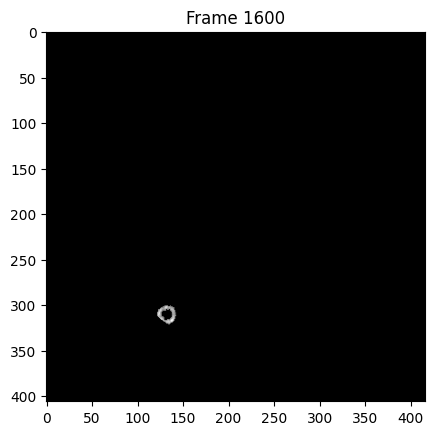

In [20]:
import matplotlib.pyplot as plt
import tifffile

# 读取 tiff 文件并设置帧范围
stack = tifffile.imread("data/020150.tiff")
start_frame = 1496
end_frame = 2597

# 显示第 i 帧和其检测结果
i = 1600  # 设置在范围内的帧号
i = min(max(i, start_frame), end_frame)
frame = stack[i]

# 用 CLAHE + 轮廓方法检测
# ...略...
# cv2.circle(result, center, radius, (255,0,0), 2)

plt.imshow(frame, cmap='gray')
plt.title(f"Frame {i}")
plt.show()


#### Internal stem thickness

In [22]:
import cv2
import numpy as np
wall_thicknesses = []
pixel_spacing = 0.084  # mm per pixel
stack = tifffile.imread("data/020150.tiff")
for i in range(1600, 1900 + 1):
    frame = stack[i]
    
    # CLAHE增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(frame)

    # 二值化
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # 确保是单通道
    if len(binary.shape) == 3:
        binary = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
    # 确保是uint8类型
    binary = binary.astype(np.uint8)
    # 查找轮廓
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) < 1:
        continue

    # 找外轮廓（最大面积）
    outer = max(contours, key=cv2.contourArea)
    (_, _), outer_radius = cv2.minEnclosingCircle(outer)

    # 反转图像寻找内孔（黑色区域）
    binary_inv = cv2.bitwise_not(binary)
    inner_contours, _ = cv2.findContours(binary_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 过滤掉面积过小和在边界上的区域，只保留在外轮廓内部的
    inner_candidates = []
    for cnt in inner_contours:
        if cv2.contourArea(cnt) > 100:
            # 取轮廓中心
            M = cv2.moments(cnt)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            # 判断中心点是否在外轮廓内
            if cv2.pointPolygonTest(outer, (cx, cy), False) > 0:
                inner_candidates.append(cnt)
    if inner_candidates:
        inner = max(inner_candidates, key=cv2.contourArea)
        (_, _), inner_radius = cv2.minEnclosingCircle(inner)
    else:
        inner_radius = 0

    wall_thickness = outer_radius - inner_radius
    wall_thicknesses.append(wall_thickness)

# 换算为毫米
wall_thicknesses_mm = [t * pixel_spacing for t in wall_thicknesses]
print(f"平均壁厚（mm）: {np.mean(wall_thicknesses_mm):.2f}")

平均壁厚（mm）: 0.98


In [23]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt

# 参数
pixel_spacing = 0.084  # mm/pixel
start_frame = 1600
end_frame = 1900
tiff_path = "data/020150.tiff"

# 加载图像堆栈
stack = tifffile.imread(tiff_path)
wall_thicknesses_mm = []

for i in range(start_frame, end_frame + 1):
    frame = stack[i]

    # CLAHE增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(frame)

    # 二值化
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = binary.astype(np.uint8)

    # 外轮廓
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        continue
    outer = max(contours, key=cv2.contourArea)
    outer_area = cv2.contourArea(outer)
    outer_radius = np.sqrt(outer_area / np.pi)
    # print(f"[Frame {i}] Outer area: {outer_area}")

    # 内轮廓（反转图像）
    binary_inv = cv2.bitwise_not(binary)
    inner_contours, _ = cv2.findContours(binary_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    inner_candidates = []
    for cnt in inner_contours:
        area = cv2.contourArea(cnt)
        if area > 100:
            M = cv2.moments(cnt)
            if M["m00"] == 0: continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            if cv2.pointPolygonTest(outer, (cx, cy), False) > 0:
                inner_candidates.append(cnt)

    if inner_candidates:
        inner = max(inner_candidates, key=cv2.contourArea)
        inner_area = cv2.contourArea(inner)
        inner_radius = np.sqrt(inner_area / np.pi)
    else:
        inner_radius = 0  # 实心或内圈未识别

    thickness = (outer_radius - inner_radius) * pixel_spacing
    wall_thicknesses_mm.append(thickness)

# 输出
print(f"平均壁厚（mm）: {np.mean(wall_thicknesses_mm):.2f}")

# # 可视化
# plt.plot(range(start_frame, end_frame + 1), wall_thicknesses_mm)
# plt.xlabel("Frame Index")
# plt.ylabel("Wall Thickness (mm)")
# plt.title("Stalk Wall Thickness Across Frames")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

平均壁厚（mm）: 0.67


[Frame 1900] inner candidate area: 168075.0
       Frame  Wall Thickness (mm)  Outer Diameter (mm)  Wall/Outer Ratio
count    0.0                  0.0                  0.0               0.0
mean     NaN                  NaN                  NaN               NaN
std      NaN                  NaN                  NaN               NaN
min      NaN                  NaN                  NaN               NaN
25%      NaN                  NaN                  NaN               NaN
50%      NaN                  NaN                  NaN               NaN
75%      NaN                  NaN                  NaN               NaN
max      NaN                  NaN                  NaN               NaN


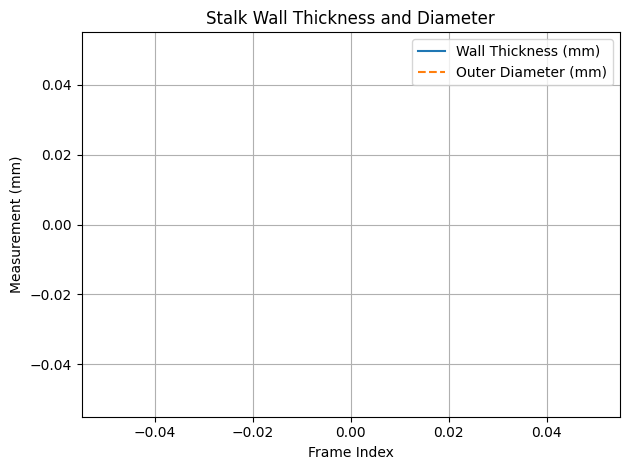

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4424].


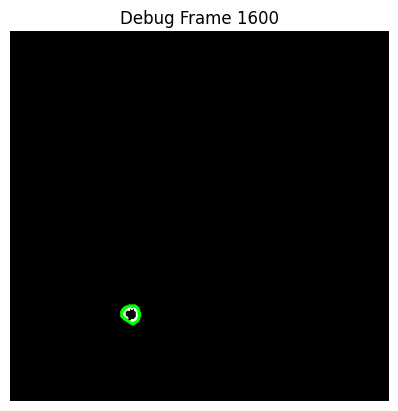

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4157].


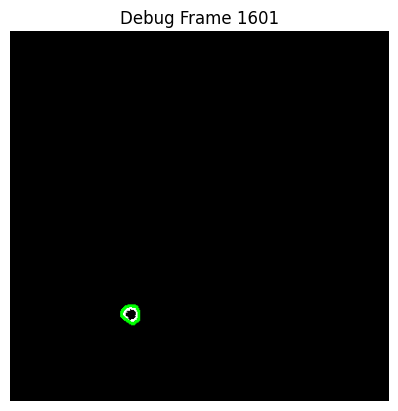

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4373].


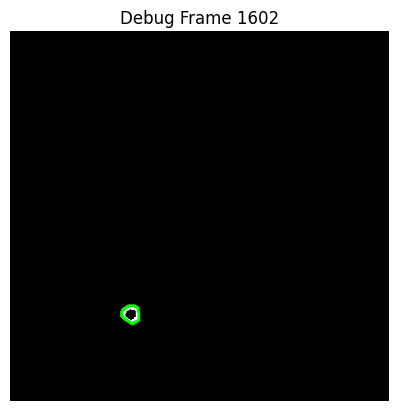

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4493].


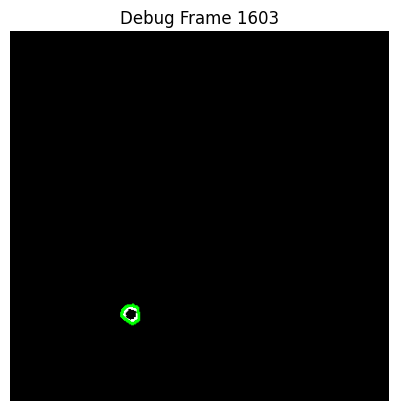

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4443].


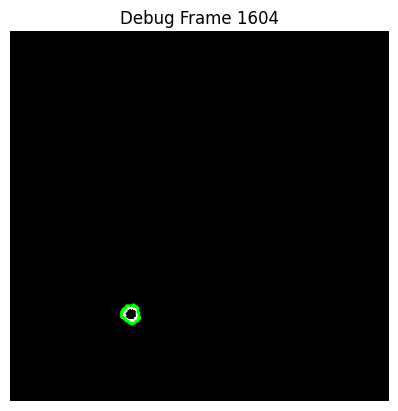

In [25]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import pandas as pd

# === 参数设置 ===
pixel_spacing = 0.084  # mm/pixel
start_frame = 1600
end_frame = 1900
tiff_path = "data/020150.tiff"

# === 数据容器 ===
wall_thicknesses_mm = []
outer_diameters_mm = []
frame_indices = []
debug_frames = []

# === 加载图像堆栈 ===
stack = tifffile.imread(tiff_path)

# === 主循环 ===
for i in range(start_frame, end_frame + 1):
    frame = stack[i]

    # CLAHE增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(frame)

    # 二值化
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = binary.astype(np.uint8)

    # 外轮廓
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        continue
    outer = max(contours, key=cv2.contourArea)
    outer_area = cv2.contourArea(outer)
    outer_radius = np.sqrt(outer_area / np.pi)

    # 反转图像 -> 找内孔
    binary_inv = cv2.bitwise_not(binary)
    inner_contours, _ = cv2.findContours(binary_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    inner_candidates = []
    for cnt in inner_contours:
        area = cv2.contourArea(cnt)
        if 30 < area < outer_area * 0.9:
            M = cv2.moments(cnt)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            if cv2.pointPolygonTest(outer, (cx, cy), False) > 0:
                inner_candidates.append(cnt)

    if inner_candidates:
        inner = max(inner_candidates, key=cv2.contourArea)
        inner_area = cv2.contourArea(inner)
        inner_radius = np.sqrt(inner_area / np.pi)
    else:
        inner_radius = 0

    wall_thickness = outer_radius - inner_radius

    # 判断壁厚是否合理
    if inner_radius > 0 and wall_thickness < outer_radius * 0.8:
        wall_thicknesses_mm.append(wall_thickness * pixel_spacing)
        outer_diameters_mm.append(2 * outer_radius * pixel_spacing)
        frame_indices.append(i)
    else:
        debug_frames.append((i, frame.copy(), outer, inner_candidates if inner_radius > 0 else []))
print(f"[Frame {i}] inner candidate area: {area}")
# === DataFrame 保存结果 ===
df = pd.DataFrame({
    "Frame": frame_indices,
    "Wall Thickness (mm)": wall_thicknesses_mm,
    "Outer Diameter (mm)": outer_diameters_mm,
    "Wall/Outer Ratio": np.array(wall_thicknesses_mm) / np.array(outer_diameters_mm)
})
print(df.describe())

# 可选：保存为 CSV 文件
# df.to_csv("stalk_wall_thickness.csv", index=False)

# === 趋势图可视化 ===
plt.figure()
plt.plot(df["Frame"], df["Wall Thickness (mm)"], label="Wall Thickness (mm)")
plt.plot(df["Frame"], df["Outer Diameter (mm)"], label="Outer Diameter (mm)", linestyle='--')
plt.xlabel("Frame Index")
plt.ylabel("Measurement (mm)")
plt.title("Stalk Wall Thickness and Diameter")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 异常帧可视化（最多展示5帧） ===
for (idx, dbg_frame, outer, inner_list) in debug_frames[:5]:
    vis = cv2.cvtColor(dbg_frame, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(vis, [outer], -1, (0, 255, 0), 2)
    for ic in inner_list:
        cv2.drawContours(vis, [ic], -1, (0, 0, 255), 2)
    plt.imshow(vis)
    plt.title(f"Debug Frame {idx}")
    plt.axis("off")
    plt.show()